In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pickle
from pathlib import Path
import torch

network_pkl = "models/baseline-cifar10-32x32-uncond-vp.pkl"
batch_size = 1
device = "cuda"

# Load network.
#print(f'Loading network from "{network_pkl}"...')
#with dnnlib.util.open_url(network_pkl) as f:
#    net = pickle.load(f)['ema'].to(device)
with open(network_pkl, 'rb') as f:
    net = pickle.load(f)['ema'].to(device) 

if Path("latents.pt").exists():
    latents = torch.load('latents.pt')
else:
    # Pick latents and labels.
    latents = torch.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)
    # save latents to file
    torch.save(latents, 'latents.pt')

class_labels = None
if net.label_dim:
    class_labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[batch_size], device=device)]

def res_to_img(res):
    return (res * 127.5 + 128).clip(0, 255).to(torch.uint8).cpu().numpy().squeeze().transpose(1,2,0)

latents.mean()

tensor(0.0072, device='cuda:0')

18it [00:01, 15.91it/s]

tensor(0.3690, dtype=torch.float64)


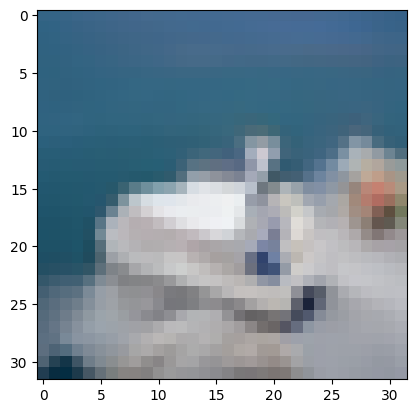

In [26]:
import torch
import numpy as np
from tv_snr.snr_schedules import *
from tv_snr.sdes import *
from tv_snr.scale_schedule import *
from tv_snr.sampler import *
from tv_snr.adaptive_scale_sampler import *
from tv_snr.snr import *
from tv_snr.constants import image_key
import matplotlib.pyplot as plt

T = 18
sigma_max=80.0

snr_sch = InverseSigmoid(slope=2., shift=0., t_min=(1/501), t_max=(80/81))
scale_sch = FMScale(snr_sch)  # ConstantScale(snr_sch)
sde = Scale_SNR_SDE(
    snr_sch=snr_sch,
    scale_sch=scale_sch,
    invariant=False,
    disc_type="forward",
    log_deriv=True
)
rsde = sde.reverse(stochastic=False)

sampler = SNRHeunAdaptiveScale(
    T=T,
    time_schedule=None,
    reverse_process = rsde,
    denoiser = net,
    out_var_scaler=1.0,
    scale_input=False,
    snr_key="gamma",
    std_key = "sigma",
    noise_pred_key = "eps_pred",
    max_stoch_std=float('inf'),
    min_stoch_std=0.0,
    clip_stoch_std=False,
    selected_stoch=False,
    save_progress=True,
    conditional=False
) 

result = sampler.denoise({image_key: latents})
print(result[0]["image"].std())

img = res_to_img(result[0]["image"])
plt.imshow(img)
plt.show()